## Executive Summary

### Problem Statement

Roads are represented as a sequence of spirals in the ZRN. This representation although is faithful to the physics of roads, poses challenges in the mathematical treatment. Projecting points in the (x, y) onto road segments in a very common operation on vehicle but the projection is hard to compute correctly and efficiently because the distance function from (x, y) points to road segment has multiple local extremas.

This report provides constraints on the spirals we generate to represent road segments and a detailed procedure to obtain minimal distance projection of inertial points on road segments. (The current implementation works for most of the cases but breaks down in certain scenarios demonstrated later in the document)

* Every spiral piece {s1, s2} must satisfy: 0 <= s1 < s2 < Sqrt[s1^2 + Pi/2]
* This report also provides a way to classify points into 7 different categories and provides the distance minimization algorithm to use for each of those categories such that we find the global optimum

### High Level Action Items

* Update the roads API distance computation logic, ensuring that we do not break compatibility with old ZRNs
* (eventually) Modify the reference line generation algorithm to generate spirals that play nicely with these constraints
* (eventually) Update the ZRN to use the new spirals

## Setup

In [1]:
SquaredNorm = Dot[#, #] &;

(* Workaround for a mathematica bug -
   apply ArcCurvature to all pieces in a Piecewise function *)
PiecewiseArcCurvature[pwf_Piecewise, z_] :=
  Piecewise[
    {ArcCurvature[#[[1]], z], #[[2]]} & /@
    Replace[List @@ pwf, {{f__}, default_} -> {f, {default, True}}]];

xySimplify[expr_] := FullSimplify[expr] /. {
    FresnelC[z_] -> Sqrt[2/Pi]*x[Sqrt[Pi/2]*z],
    FresnelS[z_] -> Sqrt[2/Pi]*y[Sqrt[Pi/2]*z],
    Csc[z_] -> 1/HoldForm[Sin][z]} // FullSimplify

exportLast[filename_] := Export["/Users/lgarg/Desktop/roads-geometry-images/" <> filename, %];

This notebook uses the Wolfram Engine and the Wolfram Language Kernel for Jupyter. To get these running on your machine, install the [Free Wolfram Engine for Developers](https://www.wolfram.com/engine/) and the [Jupyter kernel](https://github.com/WolframResearch/WolframLanguageForJupyter)

## Computing the minimal distance mapping for spirals

### Clothoid: Introduction

The following equations describe a general Euler spiral parametrized by "s", the arc length.

In [6]:
p[s_] = {Integrate[Cos[t^2], {t, 0, s}], Integrate[Sin[t^2], {t, 0, s}]};
t[s_] = D[p[s], s];
n[s_] = Cross[t[s]];
k[s_] = ArcCurvature[p[s], s];


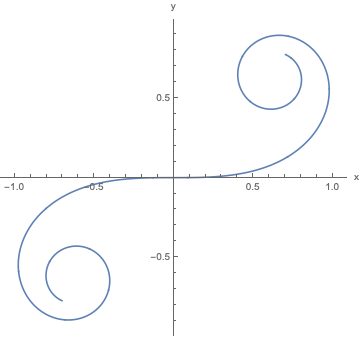

In [10]:
ParametricPlot[p[s], {s, -3, 3}, AxesLabel -> {"x", "y"}]
exportLast["spiral-plot.svg"];

Euler spiral is important in the design of roads and railroad tracks due to its property that the curvature at any point on the spiral is directly proportional to the arc length. One can think of the centripetal force acting on a vehicle as it moves along the road, if the road is a a straight line (curvature = 0) followed by a circular arc (curvature = k), the centripetal force jumps from 0 to a finite value as soon as the vehicle enters the circular arc. In the case of a spiral, the force increases gradually allowing for better control. Spiral and circular roads and their curvatures are shown below:

In [12]:
spiralRoad[s_] = Piecewise[{{{s/10, 0}, s <= 0}}, p[s]];
circularRoad[s_] = Piecewise[{{{s/10, 0}, s <= 0}}, {Sin[s], 1 - Cos[s]}];


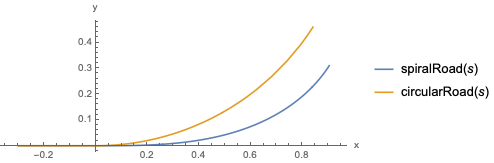

In [14]:
ParametricPlot[{spiralRoad[s], circularRoad[s]}, {s, -3, 1},
 PlotRange -> All,
 PlotLegends -> "Expressions",
 AxesLabel -> {"x", "y"}]


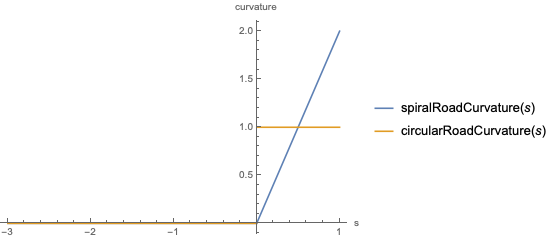

In [15]:
spiralRoadCurvature[s_] = PiecewiseArcCurvature[spiralRoad[s], s];
circularRoadCurvature[s_] = PiecewiseArcCurvature[circularRoad[s], s];

Plot[{spiralRoadCurvature[s], circularRoadCurvature[s]}, {s, -3, 1},
 PlotRange -> All,
 PlotLegends -> "Expressions",
 AxesLabel -> {"s", "curvature"}]

Often when driving, we need to map entities from inertial coordinates (x, y) to the road segment's coordinates, i.e. (s, t) where s denotes the distance travelled along the road and t denotes the perpendicular distance from the road. p[s] is a point on the spiral closest to {x, y} and the distance is t. Not all points can be mapped onto the road segment since it is made of finite spirals. To handle such cases, we extrapolate the ends of the road segment using straight lines. The algorithm is presented below:

**Input**:
```
  r: RoadSegment
  si: Spirals comprising "r", i=1...N
  p: Point to map onto "r"
```

**Output:**
```
  Projection of point "p" on "r"
```

**Assumptions:**
```
  MinDistanceProjection routine is available to compute
  projection for any (point, geometry) pair, i.e. it can
  compute (s, t) projection for point on a geometrical primitive
  
  Extrapolate routine is available to extrapolate ends of
  spirals using line segments
```

**Procedure:**
```
  let geometries = {Extrapolate[s1], s1, s2, ..., sN, Extrapolate[sN]};
  let projections = Map[g -> MinDistanceProjection[p, g], geometries];
  return projection with the smallest "t" value
```

The Extrapolate routine is straightforward and just requires computing the derivatives at the ends of the spiral. MinDistanceProjection needs to be able to minimize the distance function from the point to the spiral. The following section illustrates why this problem is non-trivial.

In [18]:
d[s_, {px_, py_}] = p[s] - {px, py} // SquaredNorm;


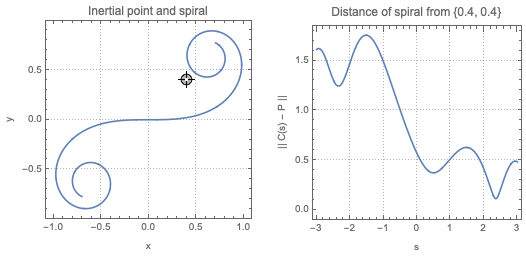

In [19]:
Module[{pt = {0.4, 0.4}}, Row[{
   LocatorPane[pt, ParametricPlot[
     p[s], {s, -3, 3},
     PlotLabel -> "Inertial point and spiral",
     ImageSize -> {250, 250},
     FrameLabel -> {"x", "y"},
     PlotTheme -> "FrameGrid",
     AspectRatio -> Full]],
   Spacer[20],
   Plot[
     EuclideanDistance[p[s], pt], {s, -3, 3},
     PlotLabel -> "Distance of spiral from " <> ToString[pt],
     ImageSize -> {250, 250},
     FrameLabel -> {"s", "|| C(s) - P ||"},
     PlotTheme -> "FrameGrid",
     AspectRatio -> Full]}]]

exportLast["distance-function-multiple-extrema.svg"];

It is evident from the above plots that the distance function for a point and spiral is hard to optimize in the general case since it has multiple local extrema. Efficient root finding and minimization algorithms exist for functions that guarantee a single extremum but they cannot be used in this scenario. Finding a global optimum would require iterating over the entire curve which makes the projection routine prohibitively expensive, since it is a very common operation on vehicle.

### Summary of the current distance minimization implementation for spirals

The current implementation looks at the derivative of the distance function to figure out if the distance function contains any minimas in the range {sMin, sMax}. It makes the following checks:

1. d'[sMin] < 0 && d'[sMax] < 0 => Distance function is decreasing all the way, s2 is the minima
2. d'[sMin] < 0 && d'[sMax] > 0 => There's a minima in (sMin, sMax), use Brent minimization
3. d'[sMin] > 0 && d'[sMax] < 0 => One of s1 or s2 is the minimum. Take the one which is shorter
4. d'[sMin] > 0 && d'[sMax] > 0 => Distance function is increasing all the way, s1 is the minima

This logic is almost correct but condition 1 is not always true and fails for a small subset of the xy plane.

### Can we generate spirals with at-most one minima in the distance function?

Notice that the extrema in the distance function for a point "p", correspond to the feet of normals drawn from "p" onto the spiral. Which means that if it is possible to drop two or more normals from "p" to the spiral, then the distance function will have multiple extrema. The following plot shows the region of xy plane obtained by taking the intersection of normals at points s1 and s2 on the spiral;

In [21]:
(* Point of intersection of normals at s1 and s2 *)
solution = Solve[
   {x, y} == p[s1] + d1 * n[s1] &&  (* normal at s1 *)
   {x, y} == p[s2] + d2 * n[s2],    (* normal at s2 *)
  {x, y, d1, d2}][[1]] // FullSimplify;

pi[s1_, s2_] = {x, y} /. solution;


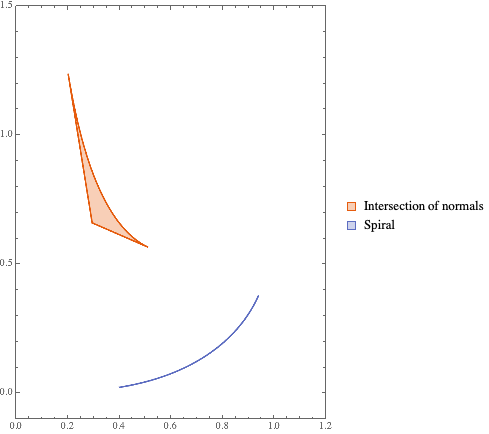

In [24]:
With[{sMin = 0.4, sMax = Sqrt[0.4^2 + 1]},
 ParametricPlot[{pi[s1, s2], p[s1]}, {s1, sMin, sMax}, {s2, s1, sMax},
 PlotRange -> {{0, 1.2}, {-0.1, 1.5}},
 PlotLegends -> {"Intersection of normals", "Spiral"},
 PlotTheme -> {"Scientific", "Frame"}]]

For all the points, in this region, the distance function has multiple extrema which makes it problematic for the optimization routine. This region is referred to as the problematic region (PR).


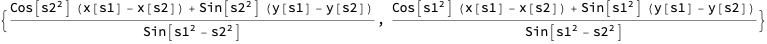

In [25]:
{d1, d2} /. solution // xySimplify

For all values of s1 and s2, such that (s1^2 - s2^2 != n * Pi), there's always a point of intersection of normals, which means that for any non-zero length spiral, **there's always a problematic region**.

### Can we keep the problematic region "far enough" from the spiral?

<a id="boundary-of-the-problematic-region"></a>Let's look at the boundaries of the problematic region. It can be seen that the two straight lines bounding the region are the normals at s1 and s2. The third boundary is where the normals intersect when the s1 and s2 are very close


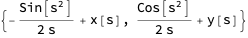

In [26]:
Limit[pi[s1, s2], {s1 -> s, s2 -> s}] // xySimplify

This is the same as:

In [27]:
ep[s_] = p[s] + n[s]/(2 s);

The locus of point of intersection of normals drawn from points close to each other is known as the [Evolute](https://en.wikipedia.org/wiki/Evolute) of the spiral.

Let's look at the left boundary of the PR. The left boundary is a subset of the normal at s1. For a fixed s1, the following plot shows the distance between p[s1] and the intersection point of normals at s1 and s2 where s2 > s1.


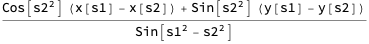

In [28]:
dd1[s1_, s2_] = d1 /. solution;
dd1[s1, s2] // xySimplify

As s2 approaches s1 the distance approaches a finite value.

In [30]:
Limit[dd1[s1, s2], {s1 -> s, s2 -> s}]


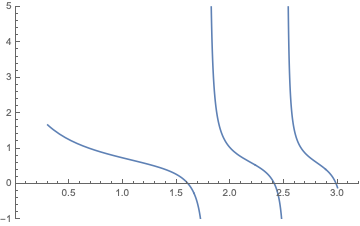

In [31]:
With[{s1=0.3}, Plot[dd1[s1, s], {s, s1, 3}, PlotRange -> {{0, 3.2}, {-1, 5}}]]

As s2^2 - s1^2 approaches Pi, the distance goes to -Infinity, since the normals become anti-parallel (For a point s on the spiral, s^2 is the angle that the tangent makes with the x axis). From the plot above, it is easy to conclude that there lies a value of s between s1 and Sqrt[s1^2 + Pi] such that the distance of the problematic region from the spiral becomes 0. Let's look at the value of s2 for which the distance goes to 0.

In [32]:
sCritical[s1_] := With[
   {sMin = s1, sMax = Sqrt[s1^2 + Pi]},
   NSolve[And[Numerator[dd1[s1, s]] == 0, s > sMin, s <= sMax], s]];


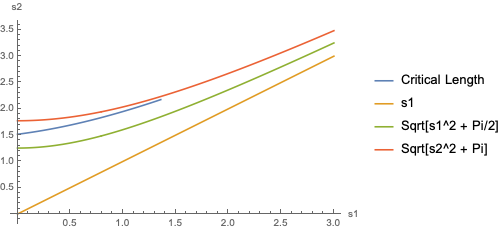

In [33]:
Plot[{
  s /. sCritical[s1][[1]],
  s1,
  Sqrt[s1^2 + Pi/2],
  Sqrt[s1^2 + Pi]},
 {s1, 0, 3},
 AxesLabel -> {"s1", "s2"},
 PlotLegends -> {
   "Critical Length", 
   "s1", 
   "Sqrt[s1^2 + Pi/2]", 
   "Sqrt[s2^2 + Pi]"}]

The y intercept of the critical length is:

In [34]:
NSolve[And[Numerator[dd1[0, s]] == 0, s > 0, s <= Sqrt[Pi]], s, WorkingPrecision -> 20]

I haven't been able to come up with a closed form expression but this is the root of Dot[p[s], D[p[s],s]] near Pi/2. If someone is interested in exploring this deeper, I recommend taking a look at the [Fresnel auxillary function G](https://reference.wolfram.com/language/ref/FresnelG.html).

From the plot above, it can be seen that Sqrt[s1^2 + Pi/2] is always less than the critical length. There's nothing special about Pi/2 here but we'll be using that to limit the length of the spirals we use to represent the road segment. This will guarantee that the problematic region is alteast some distance away from the spiral.

### Which points must be mapped onto the spiral?

Now that we have a length constraint on the spirals, not all points in the xy plane will be able to drop a perpendicular onto the spiral and for the points that can drop a perpendicular, the perpendicular distance need not be the global optimum. When looking for argmin[d], we need to  look at all the points where d'[s] = 0 and the end points of the spiral. To simplify further analysis, we'll first look at the region in the xy plane for which the distance function has a global minima on the spiral. Once we have that region, we don't need to worry about checking the end points of the spiral.


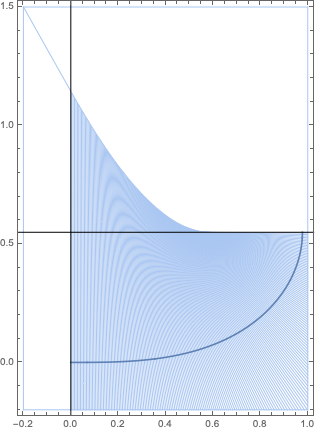

In [35]:
With[{sMin = 0.0, sMax = Sqrt[0.0^2 + Pi/2], nPts = 200},
 Show[
  VoronoiMesh[p /@ Subdivide[sMin, sMax, nPts],
   {{-0.2, 1}, {-0.2, 1.5}},
   PlotTheme -> {"Lines", "Frame"}],
  ParametricPlot[p[s], {s, sMin, sMax},
   PlotRange -> {{-0.2, 1}, {-0.2, 1.5}},
   PlotTheme -> "Frame"],
  Graphics[InfiniteLine[p[sMin], n[sMin]]],
  Graphics[InfiniteLine[p[sMax], n[sMax]]]]]

The plot above shows the Voronoi mesh created using points samples from the spiral. The dark blue line is the spiral itself and the black lines are the normals to the spiral at sMin and sMax. Notice that there are a number of small cells and two large cells in the figure. The small cells correspond to the seed points on the spiral, i.e. any point lying in those cells should be mapped to some point on the spiral. The large cells correspond to the ends of the spiral.

The two most interesting features of this diagram are:
* Line separating the cells corresponding to sMin and sMax.
* curved boundary between the region mapped to spiral and the region mapped to sMax.

To obtain the equation for these two interesting features, consider the following: For two points in a 2D place, the Voronoi mesh consists of only one edge, the perpendicular bisector of the line joining the points. Consider two points on the spiral, the ending point p[s2] and any other point p[s]. The edge separating the two cells in the Voronoi mesh for these points is the perpendicular bisector of the line joining p[s2] and p[s].

As we vary s from s1 to s2, for each value of s, we obtain 2 cells, one of which maps to s2 and the other one to s. The region of the plane which lies in the s2 cell irrespective of the value of s is the region for which the distance function does not have a global minimum on the spiral. The plot below shows the area swept by the Voronoi edge as s varies.

Repeating the same analysis for p[s1], one can find the region that always maps to s1.


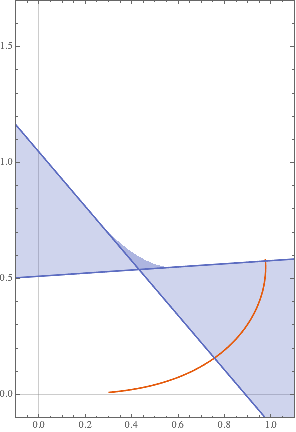

In [36]:
pb[sMin_, s_, r_] = (p[sMin] + p[s])/2 + r * Normalize[Cross[p[s] - p[sMin]]];
With[{s1 = 0.3, end = 1},
 With[{sMin = s1, sMax = Sqrt[s1^2 + Pi/2]},
  ParametricPlot[{p[s], pb[sMin + end*(sMax - sMin), s, r]},
   {s, sMin, sMax}, {r, -5, 5},
   PlotRange -> {{-0.1, 1.1}, {-0.1, 1.7}},
   PlotTheme -> "Scientific"]]]

The line separating the two large cells is just the perpendicular bisector of p[s1] and p[s2]. The curve is the envelope of perpendicular bisectors of p[s] and p[s2]. The envelope can be obtained by using the general procedure for finding envelopes as described [here](https://en.wikipedia.org/wiki/Envelope_(mathematics)#Envelope_of_a_family_of_curves). The equation for the envelope v[s] is given by:

In [38]:
(* Distance to voronoi boundary from spiral at "s" *)
dv[sMax_, s_] = SquaredNorm[p[sMax] - p[s]]/(2 Dot[p[sMax] - p[s], n[s]]);
v[sMax_, s_] = p[s] + dv[sMax, s]*n[s] // FullSimplify;

The point where the curved boundary intersects the normal at s2 is given by:


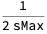

In [41]:
Limit[dv[sMax, s], {s -> sMax}] // xySimplify

The following plot shows the boundaries obtained from these equations overlayed on the Voronoi mesh to verify that the solutions we found are correct.


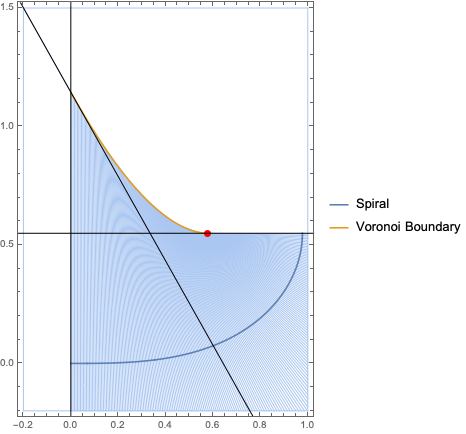

In [42]:
With[{sMin = 0.0, sMax = Sqrt[0.0^2 + Pi/2], nPts = 200},
 Show[
  VoronoiMesh[p /@ Subdivide[sMin, sMax, nPts],
   {{-0.2, 1}, {-0.2, 1.5}},
   PlotTheme -> {"Lines", "Frame"}],
  ParametricPlot[{p[s], v[sMax, s]}, {s, sMin, sMax},
   PlotRange -> {{-0.2, 1}, {-0.2, 1.5}},
   PlotLegends -> {"Spiral", "Voronoi Boundary"},
   PlotTheme -> "Frame"],
  Graphics[{PointSize -> Large, Red, Point[ep[sMax]]}],
  Graphics[PerpendicularBisector[{p[sMin], p[sMax]}]],
  Graphics[InfiniteLine[p[sMin], n[sMin]]],
  Graphics[InfiniteLine[p[sMax], n[sMax]]]]]

Now we know the boundaries of the Voronoi cells so we only need to look at the distance function if the inertial point to be mapped on the spiral lies in the Voronoi cell for the spiral. Determining if the point lies in the cell is non-trivial if we use the equations for the boundaries obtained above due to the curved boundary. This will be discussed at a later stage in the document. For now, let's assume we have the ability to tell if a point lies in the central Voronoi cell and proceed to determine the procedure for obtaining the minimal distance mapping for such points.

### How to compute the minimal distance mapping for points in the central Voronoi cell?

For points in the central Voronoi cell, we need to see how the derivative for the distance function behaves. If the derivative has only one root, then we can use any minimization algorithm and it will converge to the global optimum. Special handling will be needed in the cases when there are more than one extrema.

<a id="partition-based-on-1st-derivative-root"></a>
In the following plot, we draw a normal at each point on the spiral and observe the region where the normals intersect.


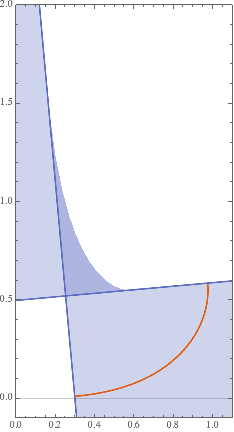

In [43]:
With[{s1 = 0.3},
 With[{sMin = s1, sMax = Sqrt[s1^2 + Pi/2]},
  ParametricPlot[{p[s], p[s] + r*n[s]}, {s, sMin, sMax}, {r, -5, 5},
   PlotRange -> {{0, 1.1}, {-0.1, 2}},
   PlotTheme -> "Scientific"]]]

The darker region in this plot shows the region from where two normals intersect. The lighter region allows dropping one normal and the white region does not allow any normals. As described [earlier](#boundary-of-the-problematic-region), the curved boundary here is given by:


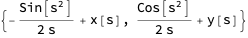

In [44]:
ep[s] // xySimplify

To see how the derivative behaves in the central Voronoi cells, let's see an overlayed plot


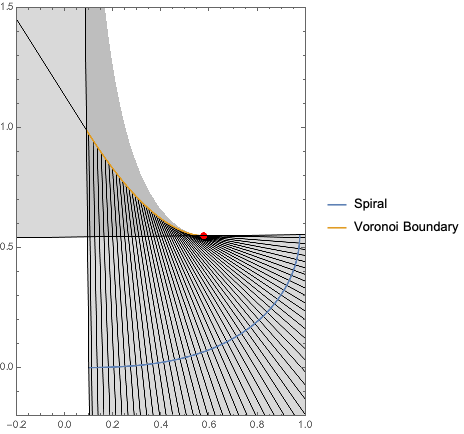

In [45]:
With[{sMin = 0.1, sMax = Sqrt[0.1^2 + Pi/2], nPts = 50},
 Show[
  ParametricPlot[p[s] + r*n[s], {s, sMin, sMax}, {r, -1, 3}, (* derivative regions *)
   PlotRange -> {{-0.2, 1}, {-0.2, 1.5}},
   PlotStyle -> Gray,
   PlotTheme -> "Frame"],
  VoronoiMesh[p /@ Subdivide[sMin, sMax, nPts], (* voronoi mesh *)
   {{-0.2, 1}, {-0.2, 1.5}},
   MeshCellStyle -> {{1, _} -> {Black}},
   PlotTheme -> {"Lines", "Frame"}],
  ParametricPlot[{p[s], v[sMax, s]}, {s, sMin, sMax}, (* spiral and voronoi boundary *)
   PlotRange -> {{-0.2, 1}, {-0.2, 1.5}},
   PlotLegends -> {"Spiral", "Voronoi Boundary"},
   PlotTheme -> "Frame"],
  Graphics[{PointSize -> Large, Red, Point[ep[sMax]]}],
  Graphics[InfiniteLine[p[sMin], n[sMin]]],
  Graphics[InfiniteLine[p[sMax], n[sMax]]]]]

It is clear from the plot that the part of the Voronoi cell that lies above the normal at s2 has 2 zeros in the derivative function and the rest of the cell has 1. So we are only really concerned with finding a procedure for computing the distance minima in the region of the Voronoi cell above the normal at s2 since for the remaining region, any minimization would work.

The derivatives of the distance function are given here:

In [46]:
d1[s_, {px_, py_}] = 2 Dot[p[s] - {px, py}, t[s]];
d2[s_, {px_, py_}] = 2 + 4 s Dot[p[s] - {px, py}, n[s]];
d3[s_, {px_, py_}] = 4 Dot[p[s] - {px, py}, n[s] - 2 s^2 t[s]];
d4[s_, {px_, py_}] = -8 s^2 - 8 s Dot[p[s] - {px, py}, 3 t[s] + 2 s^2 n[s]];

<a id="partitions-based-on-2nd-derivative-roots"></a>Let's look at the roots of the 2nd derivative of the distance function. Since 2nd derivative is just the 1st derivative of the 1st derivative, we can use the same [normal based reasoning](#partition-based-on-1st-derivative-root) to arrive at a partitioning of the region based on the number of roots of the 2nd derivative of the distance function. The following plot shows the 2nd derivative regions.


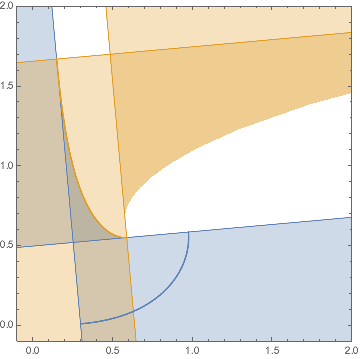

In [50]:
With[{sMin = 0.3, sMax = Sqrt[0.3^2 + Pi/2]},
 Show[
  ParametricPlot[
   {p[s] + r*n[s], ep[s] + r*t[s]},
   {s, sMin, sMax}, {r, -5, 5},
   PlotRange -> {{-0.1, 2}, {-0.1, 2}}],
  ParametricPlot[
   {p[s], ep[s]}, {s, sMin, sMax}]]]

The dark yellow region in this plot shows the area where the 2nd derivative has two roots, the light yellow area denotes one root. Notice that the area with 2 roots of d1 (dark blue) does not overlap with the area with 2 root of d2 (dark yellow). Which means that the points in PR have only one root in the second derivative of their distance function.

Let's look at the lengths of the two normals drawn from the points in the problematic region compare. This will help in understanding where the minima and the maxima lie


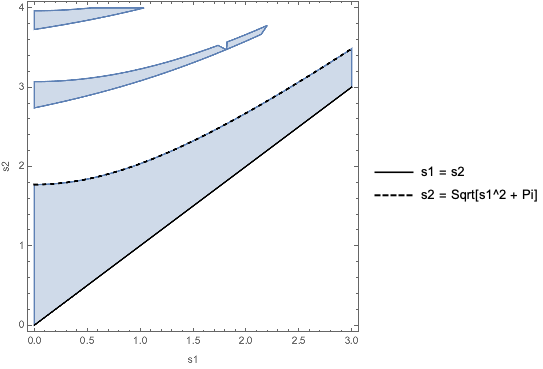

In [51]:
Show[
 RegionPlot[s2 >= s1 && d1 < d2 /. solution, {s1, 0, 3}, {s2, s1, 4},
  FrameLabel -> {"s1", "s2"}],
 Plot[{s, Sqrt[s^2 + Pi]}, {s, 0, 3},
  PlotLabel -> "Region where the first normal is shorter than the 2nd normal",
  PlotLegends -> {"s1 = s2", "s2 = Sqrt[s1^2 + Pi]"},
  PlotStyle -> {{Black}, {Thick, Black, Dashed}}]]

The plot above shows that for s1 <= s <= Sqrt[s1^2 + Pi], the length of the first normal is shorter than the second normal. Which means that the smaller root of the derivative is a minima and the bigger root is a maxima. Also notice that there will be a point in between the two roots where the second derivative is zero.


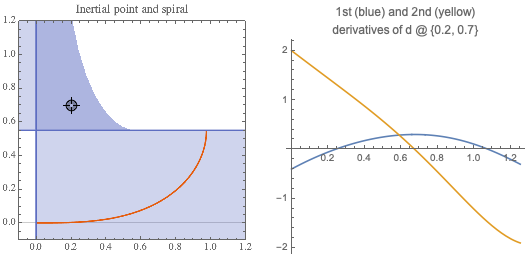

In [52]:
With[{pt = {0.2, 0.7}, sMin = 0, sMax = Sqrt[Pi/2]}, Row[{
   LocatorPane[Dynamic[pt], ParametricPlot[
     {p[s], p[s] + r*n[s]}, {s, sMin, sMax}, {r, -5, 5},
     PlotRange -> {{-0.1, 1.2}, {-0.1, 1.2}},
     PlotLabel -> "Inertial point and spiral",
     ImageSize -> {250, 250},
     PlotTheme -> "Scientific",
     AspectRatio -> Full]],
   Spacer[20],
   Plot[{d1[s, pt], d2[s, pt]}, {s, sMin, sMax},
     PlotLabel -> "1st (blue) and 2nd (yellow)\nderivatives of d @ " <> ToString[pt],
     ImageSize -> {250, 250},
     AspectRatio -> Full]}]]

To find the minima of the distance function, we need to look for the smaller root of d'

### High level algorithm


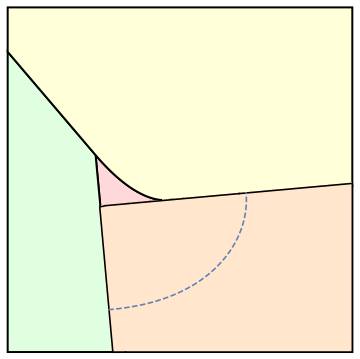

In [53]:
With[
  {sMin = 0.3, sMax = Sqrt[0.3^2 + Pi/2], nPts = 100,
   plotRange = {{-0.2, 1.5}, {-0.2, 1.5}}},
 cells = MeshPrimitives[
   VoronoiMesh[p /@ Subdivide[sMin, sMax, nPts], plotRange], 2];
 voronoi = SortBy[cells, Area] /. {s__, b1_, b2_} -> {
   Graphics[{LightRed, EdgeForm[{Black, Thick}], RegionUnion[s]}],
   Graphics[{LightGreen, EdgeForm[{Black, Thick}], b1}],
   Graphics[{LightYellow, EdgeForm[{Black, Thick}], b2}]};
 Show[
  (* Voronoi cells for the spiral and its ends *)
  voronoi[[ ;; ]],
  (* extend normat at s2 to meet normal at s1 *)
  ParametricPlot[ep[sMax] + r * n[sMax],
    {r, 0, 0.334},
    PlotStyle -> Black],
  (* Region of the xy place that must be mapped using brent *)
  RegionPlot[d1[sMin, {x, y}] <= 0 && d1[sMax, {x, y}] >= 0,
    {x, -0.2, 1.5}, {y, -0.2, 1.5},
    BoundaryStyle -> Black,
    PlotStyle -> LightOrange],
  (* Spiral *)
  ParametricPlot[p[s], {s, sMin, sMax},
    PlotRange -> plotRange,
    PlotTheme -> "Frame",
    PlotStyle -> Dashed]]]

Green: Maps to s1

Yellow: Maps to s2

Orange: Brent minimization on d in (s1, s2)

Red: Find the smaller root of d' in (s1, s2)

### Some interesting/useful pages

https://www.mathcurve.com/courbes2d.gb/cornu/cornu.shtml

https://dlmf.nist.gov/search/search?q=auxiliary%20functions%20for%20Fresnel%20integrals


### Implementation Details

Now that we know how the distance function behaves in each of the regions shows above and what algorithm to use for each region, we need to come up with an efficient logic to check the point membership in each of the regions and choose the algorithm accordingly. The following plot shows the voronoi diagram overlayed on the normals at s1 and s2


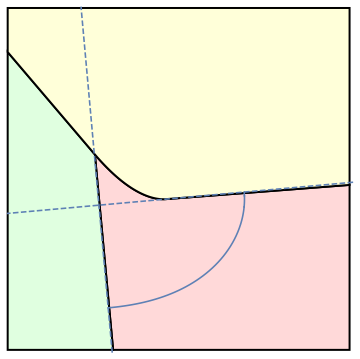

In [54]:
With[{sMin = 0.3, sMax = Sqrt[0.3^2 + Pi/2]},
 Show[voronoi[[;;]],
 ParametricPlot[p[s], {s, sMin, sMax}],
 ParametricPlot[p[sMin] + r*n[sMin], {r, -0.22, 1.5}, PlotStyle -> Dashed],
 ParametricPlot[p[sMax] + r*n[sMax], {r, -0.54, 1.18}, PlotStyle -> Dashed]]]

The normals at s1 and s2 divide the plane into 4 quadrants. Starting at the top right and going anticlockwise, label the quadrants as I, II, III and IV. Let:
```
f1[{x, y}] = d1[sMin, {x, y}];
f2[{x, y}] = d1[sMax, {x, y}];
```

The quadrant that a point {x, y} belongs to can be determined as follows:
```
Let p = {x, y};
f1[p] < 0 && f2[p] > 0 => IV
f1[p] > 0 && f2[p] > 0 => III
f1[p] > 0 && f2[p] < 0 => II
f1[p] < 0 && f2[p] < 0 => I
```

Notice that:

* Points in I map either onto the spiral or onto s2
* Points in II map either onto s1 or s2. We can compute distances to both and check
* Points in III map onto s1
* Points in IV map onto the spiral. The mapping can be obtained using Brent

#### Handling Quadrant I

For points in quadrant I, it is non-trivial to tell if they lie in the red region or the yellow region. We must use an approximation for the curved boundary here. The simplest approximation is to draw a straight line connecting the intercepts made by the voronoi edge on the normals at s1 and s2.


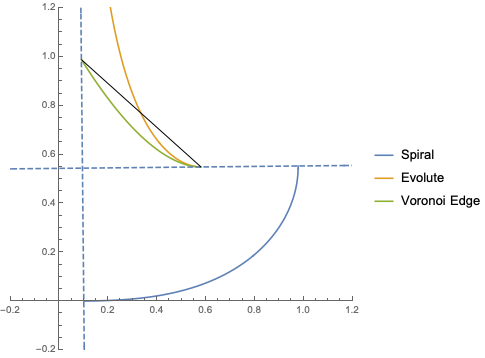

In [55]:
With[{sMin = 0.1, sMax = Sqrt[0.1^2 + Pi/2]},
 Show[
 ParametricPlot[{p[s], ep[s], v[sMax, s]}, {s, sMin, sMax},
   PlotRange -> {{-0.2,1.2}, {-0.2,1.2}},
   PlotLegends -> {"Spiral", "Evolute", "Voronoi Edge"}],
 ParametricPlot[p[sMin] + r*n[sMin], {r, -0.22, 1.5}, PlotStyle -> Dashed],
 ParametricPlot[p[sMax] + r*n[sMax], {r, -0.54, 1.18}, PlotStyle -> Dashed],
 Graphics[Line[{v[sMax, sMin], ep[sMax]}]]]]

The equation for this line can be computed and the coefficients can be stored along with the spiral. These can then be used to determine which side of this line the point lies on. If the point lies in the outer region, it can be mapped to s2 since it does not lie in the central Voronoi cell. If it lies in the internal region, we need special handling.

There are three types of points that lie in the triangular region:
1. Between normals and voronoi edge: argmin[d] lies on the spiral, d' has 2 roots
2. Between voronoi edge and evolute: argmin[d] is s2, d' has 2 roots
3. Between evolute and the straight line: argmin[d] is s2, d' has no roots

The plots below show the d and d' functions for one point of each type. The blue line is d, yellow is d'


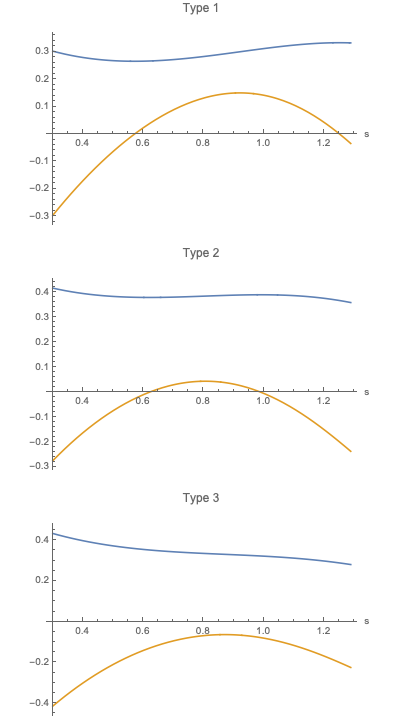

In [56]:
generatePlot[x_, y_, opts___] := Plot[{d[s, {x, y}], d1[s, {x, y}]},
  {s, 0.3, 1.2887},
  AxesLabel -> {"s"},
  opts];
GraphicsColumn[
  {generatePlot[0.4, 0.55, PlotLabel -> "Type 1"],
   generatePlot[0.38, 0.65, PlotLabel -> "Type 2"],
   generatePlot[0.45, 0.65, PlotLabel -> "Type 3"]},
   ImageSize -> Large]

From [earlier discussion](#partitions-based-on-2nd-derivative-roots) we know that there's one root in the 2nd derivative of d for all the points in this triangle. This can also be observed from the plots above. Let the root for d'' be s. For types 1 and 2, the smaller root of d' will lie in the interval (s1, s). For case 3, we'll see that sign(s1) == sign(s).

Notice that we don't really need to solve d''[s] = 0 here. All we need is a bracket for the first root of d' and since we already know that d'[s1] < 0 && d'[s2] < 0 in this region, all we need is a value of s such that d'[s] > 0. Something like this can be implemented by modifying the implementation for Brent minimization.

For the initial version, I plan on just using Brent minimization on -d''[s] to find the maxima of the derivative and then checking the sign of d'' at that value. If it is -ve, we have a Type 3 point, otherwise we have a type 1/2 point. Before using the Brent minimization, we need to ensure that d''' does not have more than one extrema. Here's a plot which shows the partitions of the xy plane based on the number of root of the 3rd derivative. Since The region we are interested in has either 0 or 1 roots, it is safe to use Brent.


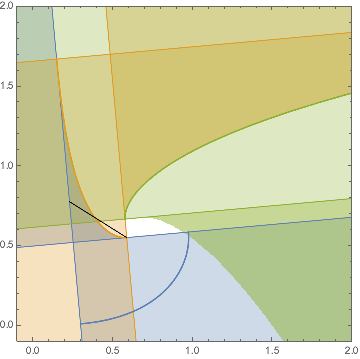

In [58]:
(* Generate regions based on the count of the roots of the 3rd derivative *)
eep[s_] = ResourceFunction["EvoluteCurve"][ep[s], s];

With[{sMin = 0.3, sMax = Sqrt[0.3^2 + Pi/2]},
 Show[
  ParametricPlot[
   {p[s] + r*n[s],
    ep[s] + r*t[s],
    eep[s] + r*n[s]},
   {s, sMin, sMax}, {r, -5, 5},
   PlotRange -> {{-0.1, 2}, {-0.1, 2}}],
  ParametricPlot[
   {p[s], ep[s], eep[s]}, {s, sMin, sMax}],
  Graphics[Line[{v[sMax, sMin], ep[sMax]}]]]]

The plot above shows that for the triangular region, there are no points for which the 3rd derivative of the distance function has more than one roots, this means we can safely use Brent to maximize the 2nd derivative. Once we have s such that d''[s] is maximized, if sign(s1) == sign(s), we can conclude that we are dealing with a type 3 point and map to s2, otherwise we can use brent again to find the root of d' in (s1, s)

## Changes needed in the spiral generation algorithm

### Summary of the current algorithm

When one creates a ZRN using the ZRN editor, the editor essentially generates certain "control points" which implicitly define constraints on a road segment. The reference line generation algorithm looks at these control points and attempts to generate a sequence of clothoids such that the curve passes through the control points (position constraint), satisfies the tangent constraints and does not have discontinuities in the curvature as one moves along the curve.

Given a sequence of control points and tangent constraints, the curve fitting algorithm does four high level steps:

1. **Interpolation**: Interpolate the control points with polylines that obey the position and tangent constraints and approximate clothoids. This is an iterative algorithm. In every iteration it adds points between control points (refine step) and then adjusts those points slightly (optimize step) so that they approximate a spiral more closely. This refine, optimize cycle is carried out a few times so that we have an approximate clothoid between consecutive control points.
2. **Fitting**: Use the generated polylines to provide initial parameter estimates to the exact clothoid fitting algorithm. The clothoid fitting algorithm requires good initial estimates for clothoid parameters to generate good clothoids otherwise the optimization algorithm ends up diverging.
3. **Simplification**: Spirals which have nearly no change in tangent are replaced by straight lines and the spirals with almost constant curvature are replaced with circular arcs.
4. **Splitting**: Now that we have exact clothoids between the control points, we split these clothoids so that each of the pieces satify the tangent change constraint, i.e. the change in the slope between the initial and final ends of the clothoid. We have such a constraint to prevent clothoids that look almost like U-turns since they make it hard to create a solid inertial to spiral projection logic

### Changes needed

Since we want to use spiral pieces from only the positive side of the clothoid, we need to change the algorithm so that it does not generate spirals that cross zero. The most obvious solution to this problem is to modify the splitting step to also split spirals at s=0. This should work for most part but might lead to creation of a number of very small spirals as demonstrated in the next cell


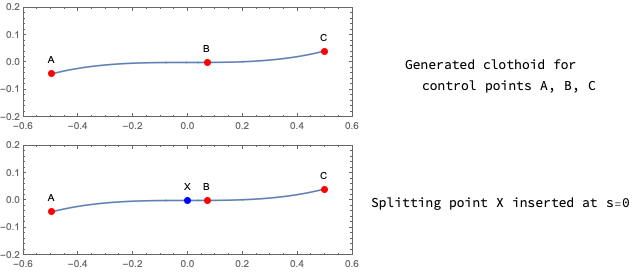

In [61]:
labelledSpiralPt[s_, text_, color_] := Graphics[{
  color, PointSize[Large], Point[p[s]],
  Black, Text[text, p[s], {0, -2}]}];
labelledSpiralPt[s_, text_] := labelledSpiralPt[s, text, Red];

With[{
  a = -0.5, b = 0.07, c = 0.5,
  plotRange = {{-0.6, 0.6}, {-0.2, 0.2}}},
 Grid[{{
   Show[
    ParametricPlot[p[s], {s, -0.5, 0.5},
     PlotRange -> plotRange,
     PlotTheme -> "Frame"],
    labelledSpiralPt[a, "A"],
    labelledSpiralPt[b, "B"],
    labelledSpiralPt[c, "C"],
    ImageSize -> Medium],
   "Generated clothoid for control points A, B, C"},
  {
   Show[
    ParametricPlot[p[s], {s, -0.5, 0.5},
     PlotRange -> plotRange,
     PlotTheme -> "Frame"],
    labelledSpiralPt[a, "A"],
    labelledSpiralPt[b, "B"],
    labelledSpiralPt[c, "C"],
    labelledSpiralPt[0, "X", Blue],
    ImageSize -> Medium],
   "Splitting point X inserted at s=0"}}]]

Notice how splitting at X created a small spiral piece BX which could have easily been a part of the spiral AX without violating the tangent change constraint.

We would like to avoid these small spirals because they can:

1. increase the computation we need do at runtime
2. increase the possibility of running into numerical issues

I currently do not have a definitive answer for how to deal with the small spirals. Here are some possibilities:

0. Live with small spirals, maybe the reasons mentioned above don't have any noticeable effect
1. If we see a small spiral, we require the user of the ZRN editor to adjust control points
2. We currently consider control points as "sacred" and never perturb them in any of the curve fitting steps. It might be possible to get rid of small spirals if we allow the curve fitting algorithm to slightly adjust the control points.

## Images


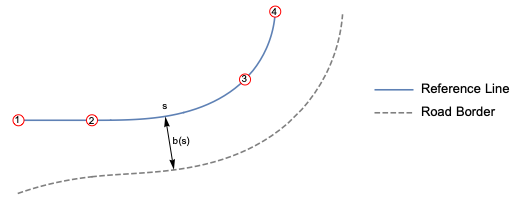

In [64]:
road[s_] := Module[{sMin=0, sMax=Sqrt[Pi/4], sLocal},
  sLocal = s - 4/10;
  Piecewise[{
    {{sLocal, 0}, sLocal <= 0},
    {p[sLocal], 0 < sLocal <= sMax}},
    radius = 1 / k[sMax];
    center = p[sMax] + n[sMax] * radius;
    offset = (Pi/2 - sMax^2) * radius + sMax;
    theta = (sLocal - offset) / radius;
    center + {Cos[theta], Sin[theta]} / k[sMax]]];

normal[s_] = Piecewise@@(List@@road[s] /. {x_List, y_} :> {{Cross[D[#[[1]], s]], #[[2]]}& /@ x, Cross[D[y, s]]});
border[s_] = 0.3074286 - 0.112381*(s-0.4) + 0.2428571*(s-0.4)^2 - 0.09333333*(s-0.4)^3;
borderPt[s_] = road[s] - border[s] * normal[s];

labelledPt[label_, pt_, offset_:{0,0}] := Graphics[
  {EdgeForm[Red], White, Disk[pt,0.03],
   Black, Text[label, Offset[offset, pt]]}];
 
Show[
  ParametricPlot[
    {road[s], road[s] - border[s] * normal[s]}, {s, 0, 1.7},
    PlotStyle -> {Default, {Dashed, Gray}},
    Frame -> False, Axes -> False,
    PlotLegends -> {"Reference Line", "Road Border"}],
  labelledPt["1", road[0], {-0.4,-0.7}],
  labelledPt["2", road[0.4], {0.5,-1}],
  labelledPt["3", road[0.4 + Sqrt[Pi/4]]],
  labelledPt["4", road[1.7], {0,-1}],
  Graphics[{Arrowheads[{-0.03, 0.03}], Arrow[Line[{road[0.8], borderPt[0.8]}]]}],
  Text["s", Offset[{0,10},road[0.8]]] // Graphics,
  Text["b(s)", Offset[{12,2}, 0.5*(borderPt[0.8]+road[0.8])]] // Graphics
]
exportLast["road-structure.svg"];


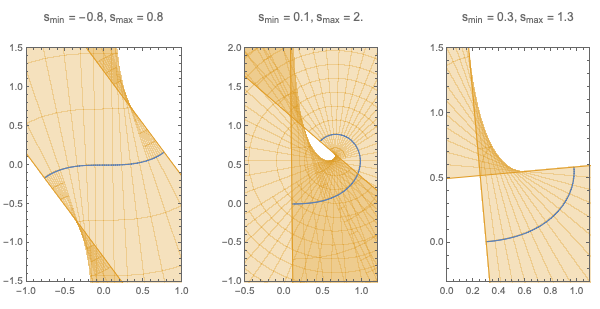

In [72]:
$PlotTheme = {"Minimal", "Frame"};
labelFn[a_, b_] := StringForm["`` = ``, `` = ``", Subscript["s", "min"], a, Subscript["s", "max"], b];

GraphicsRow[{
 With[{sMin = -0.8, sMax = 0.8},
  ParametricPlot[{p[s], p[s] + r*n[s]}, {s, sMin, sMax}, {r, -5, 5},
   PlotLabel -> labelFn[-0.8, 0.8],
   ImageSize -> {Automatic, 700},
   PlotRange -> {{-1, 1}, {-1.5, 1.5}}]],
 With[{sMin = 0.1, sMax = 2.0},
  ParametricPlot[{p[s], p[s] + r*n[s]}, {s, sMin, sMax}, {r, -5, 5},
   PlotLabel -> labelFn[0.1, 2.0],
   ImageSize -> {Automatic, 700},
   PlotRange -> {{-0.5, 1.2}, {-1, 2}}]],
 With[{sMin = 0.3, sMax = Sqrt[0.3^2 + Pi/2]},
  ParametricPlot[{p[s], p[s] + r*n[s]}, {s, sMin, sMax}, {r, -5, 5},
   PlotLabel -> labelFn[0.3, 1.3],
   ImageSize -> {Automatic, 700},
   PlotRange -> {{0, 1.1}, {-0.3, 1.5}}]]
}]

exportLast["multiple-extrema-regions.svg"];


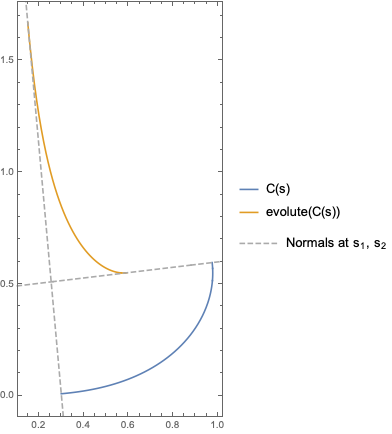

In [76]:
Show[
ParametricPlot[
  {p[s], ep[s]},
  {s, 0.3, 1.3},
  PlotLegends -> {"C(s)", "evolute(C(s))"},
  PlotTheme -> Frame
],
ParametricPlot[
  {p[0.3] + r * n[0.3],
   p[1.3] + r * n[1.3]},
  {r, -5, 5},
  PlotStyle -> {{Dashed, Lighter[Gray]}, {Dashed, Lighter[Gray]}},
  PlotLegends -> {StringForm["Normals at ``, ``", Subscript["s", 1], Subscript["s", 2]]}
]
]
exportLast["spiral-evolute.svg"];


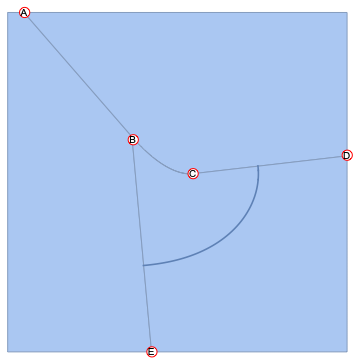

In [78]:
points = p /@ Subdivide[0.3, 1.3, 300];
Show[
  ResourceFunction["ApproximateGeneralizedVoronoiMesh"][
    TakeList[points, {1, Length[points] - 2, 1}],
    {{-0.5, 1.5}, {-0.5, 1.5}}],
  ParametricPlot[p[s], {s, 0.3, 1.3}],
  labelledPt["A", {-0.4,1.5}, {0,-1}],
  labelledPt["B", {0.24,0.75}, {0,-1}],
  labelledPt["C", ep[1.3], {0,-1}],
  labelledPt["D", p[1.3] - 0.53 * n[1.3], {0,-1}],
  labelledPt["E", {0.35, -0.5}, {0,-1}]
  ]
exportLast["spiral-voronoi.svg"];


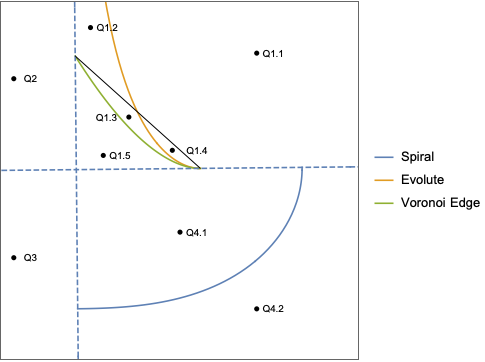

In [81]:
labelledPt2[label_, pt_, offset_:{0,0}] := Graphics[
  {Disk[pt,0.01], Text[label, Offset[offset, pt]]}];

q11 = {0.8, 1.0};
q12 = {0.15, 1.1};
q13 = {0.3, 0.75};
q14 = {0.47, 0.62};
q15 = {0.2, 0.6};
q2 = {-0.15, 0.9};
q3 = {-0.15, 0.2};
q41 = {0.5, 0.3};
q42 = {0.8, 0.0};

With[{sMin = 0.1, sMax = Sqrt[0.1^2 + Pi/2]},
 Show[
 ParametricPlot[{p[s], ep[s], v[sMax, s]}, {s, sMin, sMax},
   PlotRange -> {{-0.2,1.2}, {-0.2,1.2}},
   PlotLegends -> {"Spiral", "Evolute", "Voronoi Edge"},
   PlotTheme -> "Minimal",
   Frame -> True,
   Axes -> False],
 ParametricPlot[p[sMin] + r*n[sMin], {r, -0.22, 1.5}, PlotStyle -> Dashed],
 ParametricPlot[p[sMax] + r*n[sMax], {r, -0.54, 1.18}, PlotStyle -> Dashed],
 Graphics[Line[{v[sMax, sMin], ep[sMax]}]],
 labelledPt2["Q1.1", q11, {17,-1}],
 labelledPt2["Q1.2", q12, {17,-1}],
 labelledPt2["Q1.3", q13, {-22,-1}],
 labelledPt2["Q1.4", q14, {25,-1}],
 labelledPt2["Q1.5", q15, {17,-1}],
 labelledPt2["Q2", q2, {17,-1}],
 labelledPt2["Q3", q3, {17,-1}],
 labelledPt2["Q4.1", q41, {17,-1}],
 labelledPt2["Q4.2", q42, {17,-1}]
 ]]
exportLast["evolute-and-voronoi.svg"];


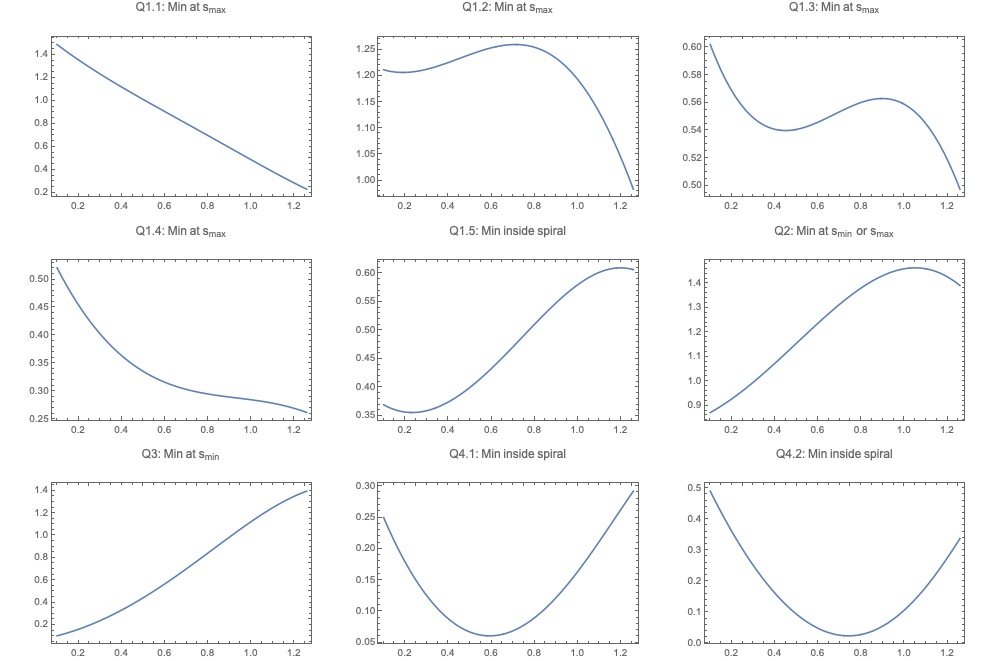

In [93]:
$PlotTheme = Default;

qq = {
  {q11, StringForm["Q1.1: Min at ``", Subscript["s", "max"]]},
  {q12, StringForm["Q1.2: Min at ``", Subscript["s", "max"]]},
  {q13, StringForm["Q1.3: Min at ``", Subscript["s", "max"]]},
  {q14, StringForm["Q1.4: Min at ``", Subscript["s", "max"]]},
  {q15, "Q1.5: Min inside spiral"},
  {q2, StringForm["Q2: Min at `` or ``", Subscript["s", "min"], Subscript["s", "max"]]},
  {q3, StringForm["Q3: Min at ``", Subscript["s", "min"]]},
  {q41, "Q4.1: Min inside spiral"},
  {q42, "Q4.2: Min inside spiral"}
};

Module[{sMin = 0.1, sMax = Sqrt[0.1^2 + Pi/2]},
  GraphicsGrid[
    ArrayReshape[
      Table[
        Plot[
          d[s, q[[1]]],
          {s, sMin, sMax},
          Frame -> True,
          Axes -> False,
          PlotLabel -> q[[2]],
          PlotRange -> All],
        {q, qq}],
      {3, 3}],
    ImageSize -> {1000, Automatic},
    Spacings -> {{{-20}}, {{10}}}]]

exportLast["distance-functions-for-points.svg"];


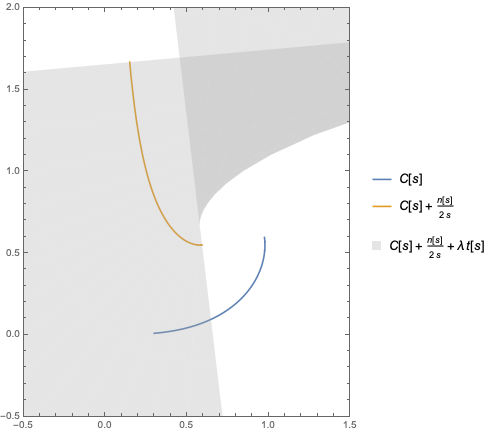

In [97]:
Show[
ParametricPlot[
  {p[s], ep[s]},
  {s, 0.3, 1.3},
  PlotLegends -> {HoldForm[C][s], HoldForm[C][s] + HoldForm[n][s]/(2s)},
  PlotRange -> {{-0.5, 1.5}, {-0.5, 2}},
  Frame -> True,
  Axes -> False
],
ParametricPlot[
  ep[s] + r * t[s],
  {r, -5, 5},
  {s, 0.3, 1.3},
  PlotLegends -> {HoldForm[C][s] + HoldForm[n][s]/(2s) + \[Lambda] HoldForm[t][s]},
  BoundaryStyle -> Transparent,
  PlotStyle -> {EdgeForm[Transparent], Lighter[Gray]}
]
]
exportLast["second-derivative-roots.svg"];


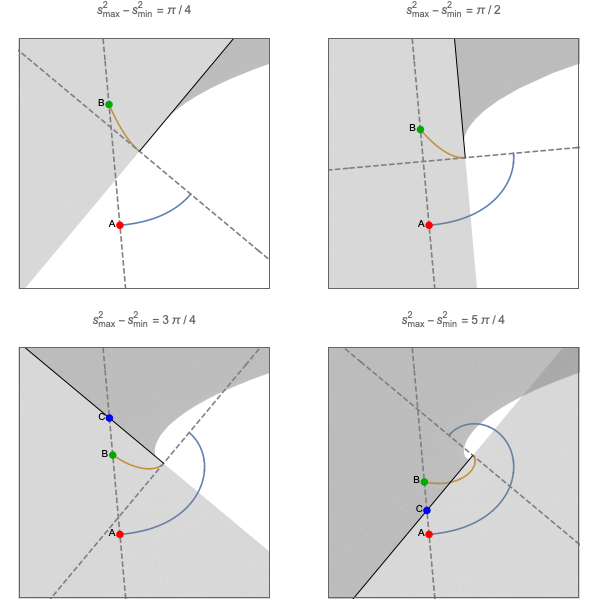

In [99]:
plot[sMin_, len_] := Module[{a, b, c, sMax=Sqrt[sMin^2 + len]},
Show[
  a = p[sMin];
  b = v[sMax, sMin];
  csolve = NSolve[{
      {cx, cy} == p[sMin] + r1 * n[sMin],
      {cx, cy} == ep[sMax] + r2 * t[sMax]},
      {cx, cy, r1, r2}];
  c = If[Length[csolve] == 0 || (r2 /. csolve[[1]]) <= 0.0, {10, 10}, {cx, cy} /. csolve[[1]]];
  ParametricPlot[
    {p[s], v[sMax, s]},
    {s, sMin, sMax},
    PlotRange -> {{-0.5, 1.5}, {-0.5, 1.5}},
    PlotLabel -> Row[
      {HoldForm[Power[Subscript[s,max],2] - Power[Subscript[s,min],2]], " = ",
        Sequence@@If[Denominator[len] == 1,
          {Numerator[len]},
          {Numerator[len], " / ", Denominator[len]}]}],
    Frame -> True,
    Axes -> False,
    PlotTheme -> "Minimal",
    ImageMargins -> -100
  ],
  ParametricPlot[
    {p[sMin] + r * n[sMin],
     p[sMax] + r * n[sMax]},
    {r, -5, 5},
    PlotStyle -> {{Gray, Dashed}}
  ],
  ParametricPlot[
    ep[s] + r * t[s],
    {s, sMin, sMax},
    {r, -5, 5},
    BoundaryStyle -> Transparent,
    PlotStyle -> {Gray, EdgeForm[Transparent]}
  ],
  Graphics[{Line[{ep[sMax], ep[sMax] + 5*t[sMax]}]}],
  Graphics[{Red, Disk[a, 0.03], Black, Text["A", Offset[{-7,1}, a]]}],
  Graphics[{Darker[Green], Disk[b, 0.03], Black, Text["B", Offset[{-7,1}, b]]}],
  Graphics[{Blue, Disk[c, 0.03], Black, Text["C", Offset[{-7,1}, c]]}]
]];

GraphicsGrid[{
{
  plot[0.3, Pi/4],
  plot[0.3, Pi/2]
},
{
  plot[0.3, 3 Pi/4],
  plot[0.3, 5 Pi/4]
}
}]

exportLast["voronoi-boundary-and-2nd-derivative.svg"];


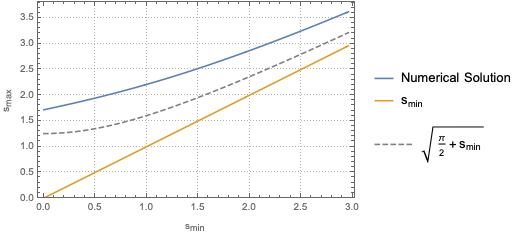

In [102]:
f[sMin_, llim_, ulim_] := sMax /. FindRoot[Dot[v[sMax, sMin] - p[sMax] - n[sMax]/(2 sMax), n[sMax]] == 0, {sMax, llim, ulim}]
Module[{s, s1 = {0.}, s2 = {f[0, 0.1, 1.8]}},
  For[i = 1, i < 300, ++i,
    s = 0.0099 * i;
    AppendTo[s1, s];
    AppendTo[s2, f[s, Last[s2], Last[s2]+0.4]]];
  Show[
    ListLinePlot[
      {Transpose[{s1, s2}], Transpose[{s1, s1}]},
      FrameLabel -> {HoldForm[Subscript["s", "min"]], Subscript["s", "max"]},
      PlotRange -> {Automatic, {0, Automatic}},
      PlotLegends -> {"Numerical Solution", Subscript["s","min"]},
      PlotTheme -> "Detailed"],
    Plot[
      Sqrt[Pi/2 + x^2],
      {x, First[s1], Last[s1]},
      PlotLegends -> {Sqrt[Subscript["s", "min"] + Pi/2]},
      PlotStyle -> {Gray, Dashed}]
  ]
]
exportLast["smax-numerical-solution.svg"];


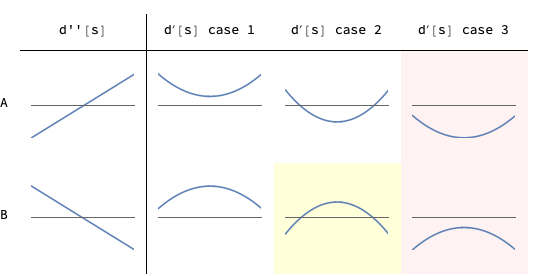

In [105]:
Grid[{
  {},
  {
    Null,
    Item["", Frame -> {{False, True}, {False, False}}],
    Null,
    Null,
    Null,
    Null
  },
  {
    Null,
    Item[ToString[D[d[s], {s, 2}]], Frame -> {{False, True}, {False, False}}],
    StringForm["`` case 1", D[d[s], s]],
    StringForm["`` case 2", D[d[s], s]],
    StringForm["`` case 3", D[d[s], s]],
    Null
  },
  {
    Null,
    Item["", Frame -> {{False, True}, {False, False}}],
    Null,
    Null,
    Null,
    Null
  },
  {
    Item["A"],
    Item[Plot[x, {x, -1, 1}, PlotTheme -> "Minimal", Axes -> {True, False}, PlotRange -> {{-1, 1}, {-1, 1}}], Frame -> {{False, True}, {False, True}}],
    Item[Plot[0.7 x^2 + 0.3, {x, -1, 1}, PlotTheme -> "Minimal", Axes -> {True, False}, PlotRange -> {{-1, 1}, {-1, 1}}], Frame -> {{True, False}, {False, True}}],
    Item[Plot[x^2 - 0.5, {x, -1, 1}, PlotTheme -> "Minimal", Axes -> {True, False}, PlotRange -> {{-1, 1}, {-1, 1}}], Frame -> {{False, False}, {False, True}}],
    Item[Plot[0.7 x^2 - 1, {x, -1, 1}, PlotTheme -> "Minimal", Axes -> {True, False}, PlotRange -> {{-1, 1}, {-1, 1}}], Background -> Lighter[Pink, 0.9], Frame -> {{False, False}, {False, True}}],
    Null
  },
  {
    Item["B"],
    Item[Plot[-x, {x, -1, 1}, PlotTheme -> "Minimal", Axes -> {True, False}, PlotRange -> {{-1, 1}, {-1, 1}}], Frame -> {{False, True}, {False, False}}],
    Plot[-0.7 x^2 + 1, {x, -1, 1}, PlotTheme -> "Minimal", Axes -> {True, False}, PlotRange -> {{-1, 1}, {-1, 1}}],
    Item[Plot[-x^2 + 0.5, {x, -1, 1}, PlotTheme -> "Minimal", Axes -> {True, False}, PlotRange -> {{-1, 1}, {-1, 1}}], Background -> LightYellow],
    Item[Plot[-0.7 x^2 - 0.3, {x, -1, 1}, PlotTheme -> "Minimal", Axes -> {True, False}, PlotRange -> {{-1, 1}, {-1, 1}}], Background -> Lighter[Pink, 0.9]],
    Null
  }
}, Spacings -> {{{Scaled[0.05]}}, {{Scaled[0.00]}}}]

exportLast["distance-derivative-options.svg"];